# Investigation of complex (self-intersecting) trajectories (Figure 5A-C)

In [1]:
%matplotlib inline
from copy import deepcopy as copy
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from aux import sgmd, Generic
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from ntwk import SimpleNtwk

## Trajectory

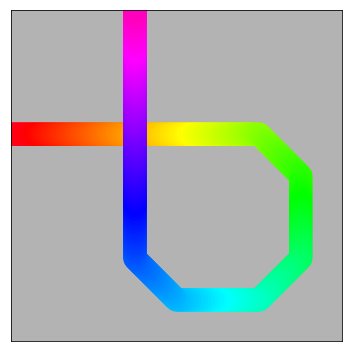

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)

x_trj = []
y_trj = []

# E
x_trj.append(np.linspace(-1, .5, 151))
y_trj.append(np.repeat(.25, 151))

# SE
x_trj.append(np.linspace(.5, .75, 36)[1:])
y_trj.append(np.linspace(.25, 0, 36)[1:])

# S
x_trj.append(np.repeat(.75, 51)[1:])
y_trj.append(np.linspace(0, -.5, 51)[1:])

# SW
x_trj.append(np.linspace(.75, .5, 36)[1:])
y_trj.append(np.linspace(-.5, -.75, 36)[1:])

# W
x_trj.append(np.linspace(.5, 0, 51)[1:])
y_trj.append(np.repeat(-.75, 51)[1:])

# NW
x_trj.append(np.linspace(0, -.25, 36)[1:])
y_trj.append(np.linspace(-.75, -.5, 36)[1:])

# N
x_trj.append(np.repeat(-.25, 151)[1:])
y_trj.append(np.linspace(-.5, 1, 151)[1:])

x_trj = np.concatenate(x_trj)
y_trj = np.concatenate(y_trj)

n = len(x_trj)

dx_trj = np.gradient(x_trj)
dy_trj = np.gradient(y_trj)

norm_trj = np.sqrt(dx_trj**2 + dy_trj**2)
dx_trj /= norm_trj
dy_trj /= norm_trj

tht_trj = np.arctan2(dy_trj, dx_trj)

ax.scatter(
    x_trj, y_trj, s=500, c=np.linspace(0, 1, n), cmap='gist_rainbow')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.set_facecolor((.7, .7, .7))

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

set_font_size(ax, 16)

## Network

In [3]:
# function for plotting oriented triangles
def get_tri_coord(x, y, tht, b, h):
    """Return coordinates of rotated triangle."""
    # get coords w/ upper left corner at origin
    xy = np.array([[0, 0], [0, -b], [h, -b/2]])
    
    # put center of mass at origin
    c_x = xy[:, 0].mean()
    c_y = xy[:, 1].mean()
    xy[:, 0] -= c_x
    xy[:, 1] -= c_y
    
    # rotate
    r = np.array([[np.cos(tht), -np.sin(tht)], [np.sin(tht), np.cos(tht)]])
    xy = np.dot(xy, r.T)
    
    # shift
    xy[:, 0] += x
    xy[:, 1] += y
    
    return xy


def tri_scatter(ax, x, y, tht, c, b, h):
    """Make scatter plot of oriented triangles."""
    polys = [
        Polygon(get_tri_coord(x_, y_, tht_, b, h), zorder=tht_)
        for x_, y_, tht_ in zip(x, y, tht)
    ]
    
    ax.add_collection(PatchCollection(polys, color=c))
    
    return ax

## Tuning

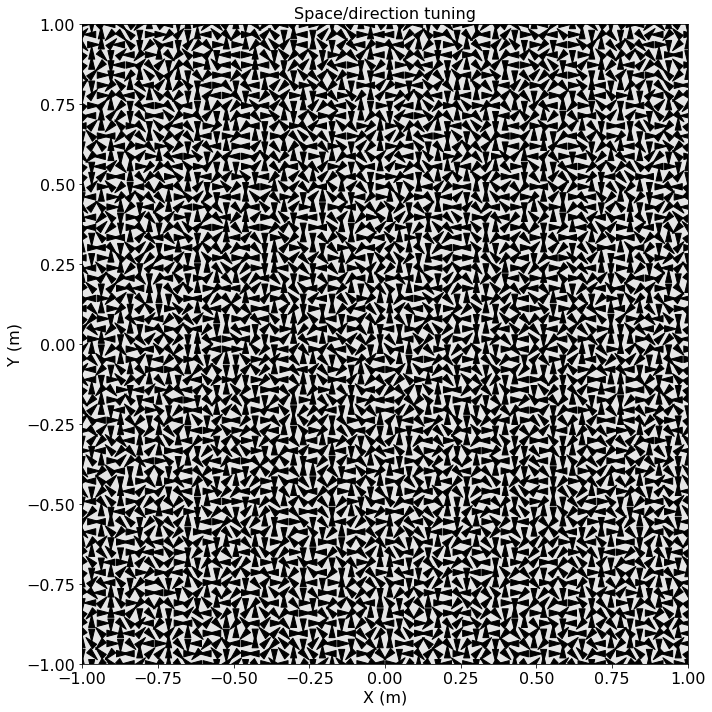

In [4]:
# network architecture
np.random.seed(0)
N_X = 64
N_Y = 64
N = N_X*N_Y
N_THT = 8

# build grid representation of cells
x_, y_ = np.meshgrid(np.linspace(-1, 1, N_X), np.linspace(-1, 1, N_Y), indexing='xy')

tht_ = np.nan * np.zeros((N_X, N_Y))
for r_ctr in range(N_Y):
    tht_row = np.concatenate([
        (np.random.permutation(N_THT) - (N_THT/2)) * 2*np.pi/N_THT
        for ctr in range(int(N_X/N_THT))
    ])
    tht_[r_ctr, :] = copy(tht_row)
    
x = x_.flatten()
y = y_.flatten()
tht = tht_.flatten()

# plots summarizing network architecture
fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)

# show distribution of place/theta tunings
tri_scatter(ax, x, y, tht, N_X*N_Y*['k'], .02, .04)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_facecolor((.9, .9, .9))
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Space/direction tuning')

set_font_size(ax, 16)

## Connectivity

$
w(\Delta x, \Delta y, \Delta \theta) = 
\exp\left(-\cfrac{\Delta x^2 + \Delta y^2}{2\lambda_{xy}^2}\right)
\exp\left(-\cfrac{\Delta \theta^2}{2\lambda_\theta^2}\right)
$

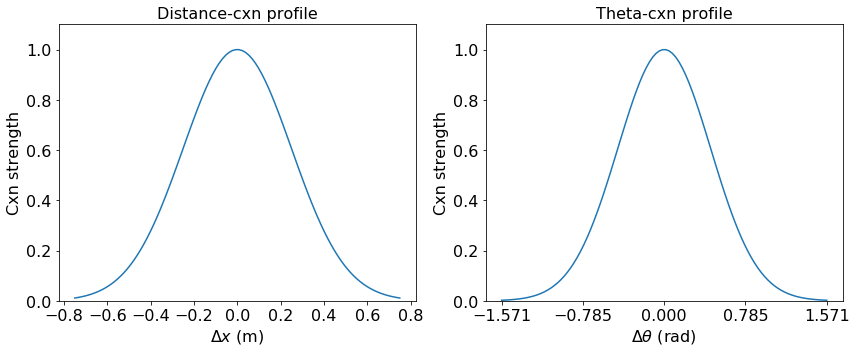

In [5]:
L_XY_W = .25
L_THT_W = np.pi/7

x_ = np.tile(x[:, None], (1, len(x)))
y_ = np.tile(y[:, None], (1, len(y)))
tht_ = np.tile(tht[:, None], (1, len(tht)))

dx = x_ - x_.T
dy = y_ - y_.T
dtht = np.min(np.array([
    np.abs(tht_ - tht_.T),
    np.abs(tht_ - tht_.T + 2*np.pi),
    np.abs(tht_ - tht_.T - 2*np.pi),
]), axis=0)

w = np.exp(-(dx**2 + dy**2)/(2*L_XY_W**2)) * np.exp(-(dtht**2)/(2*L_THT_W**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# show connectivity profiles
## x, y
d_l_xy_w = np.linspace(-.75, .75, 100)
axs[0].plot(d_l_xy_w, np.exp(-(d_l_xy_w**2)/(2*L_XY_W**2)))
axs[0].set_xlabel('$\Delta x$ (m)')
axs[0].set_title('Distance-cxn profile')

## tht
tht_l_tht_w = np.linspace(-np.pi/2, np.pi/2, 100)
axs[1].plot(tht_l_tht_w, np.exp(-(tht_l_tht_w**2)/(2*L_THT_W**2)))
axs[1].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
axs[1].set_xlabel(r'$\Delta\theta$ (rad)')
axs[1].set_title('Theta-cxn profile')

for ax in axs:
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Cxn strength')
    set_font_size(ax, 16)

## LTP-IE profile

In [9]:
# construct LTP-IE profile
S_X = .2
S_Y = .2
S_THT = np.pi/16
BETA = 20


def calc_ltp_ie(x, y, tht, x_0, y_0, tht_0, s_x, s_y, s_tht, beta):
    """Return LTP-IE strength for location/angle (x_0, y_0, th_0)."""
    dx_2 = ((x - x_0)**2)/(2*s_x**2)
    dy_2 = ((y - y_0)**2)/(2*s_y**2)
    dtht = np.min(np.array([
        np.abs(tht - tht_0),
        np.abs(tht - tht_0 + 2*np.pi),
        np.abs(tht - tht_0 - 2*np.pi),
    ]), axis=0)
    dtht_2 = (dtht**2)/(2*s_tht**2)
    exponent = -(dx_2 + dy_2 + dtht_2)
    return sgmd(beta * (np.exp(exponent) - 0.5))


ltp_ie = np.nan * np.zeros(len(x))
for x_0, y_0, tht_0 in zip(x_trj, y_trj, tht_trj):
    
    ltp_ie_tmp = calc_ltp_ie(
        x, y, tht, x_0, y_0, tht_0, S_X, S_Y, S_THT, BETA)
    
    ltp_ie = np.nanmax(np.array([ltp_ie, ltp_ie_tmp]), axis=0)

## Run simulations

In [10]:
## build ntwk
ntwk = SimpleNtwk(w=w, ltp_ie=ltp_ie, max_active=10, v_th=11, rp=6)

# run smln in forward and reverse
xy_trgs = {'fwd': (-1, .25), 'rev': (-.25, 1)}
rslts = {}

for k, (x_trg, y_trg) in xy_trgs.items():
    ## build stim
    t_smln = 50
    inp_g = 5  ### bkgd yielding LTP-IE-differentiated baseline

    inp_ext = np.zeros((t_smln, N))  ### triggering stim

    ### give sqexp input decaying from trigger focus
    l_trg = .2
    a_trg = 3

    d_trg = np.sqrt((x-x_trg)**2 + (y-y_trg)**2)
    ### add single timestep trigger input
    inp_ext[1, :] = a_trg*np.exp(-(d_trg)**2 / (2*l_trg**2))

    ## run smln
    rslt = ntwk.run(inp_ext, inp_g)
    
    rslts[k] = copy(rslt)

## Plot LTP-IE profile and replay spike order

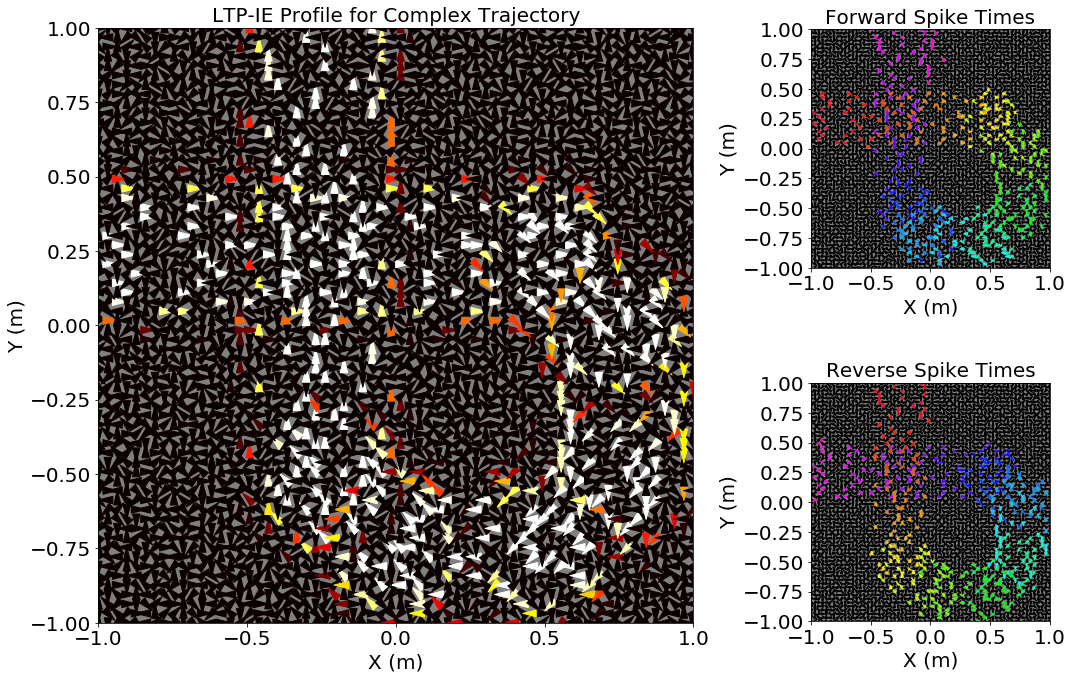

In [11]:
# plot LTP-IE and two spike sequences
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(15, 10), tight_layout=True)
axs = []
axs.append(fig.add_subplot(gs[:, :2]))
axs.append(fig.add_subplot(gs[0, 2]))
axs.append(fig.add_subplot(gs[1, 2]))

# plot LTP-IE profile
tri_scatter(axs[0], x, y, tht, cm.get_cmap('hot')(ltp_ie), .025, .05)
axs[0].set_title('LTP-IE Profile for Complex Trajectory')

# plot spike order
for ax, rslt, label in zip(axs[1:], [rslts['fwd'], rslts['rev']], ['Forward', 'Reverse']):
    cmap = cm.get_cmap('gist_rainbow')

    spk_order = np.nan * np.zeros(N)
    for n_ctr in range(N):
        if np.any(rslt.spks[:, n_ctr]):
            spk_order[n_ctr] = np.nonzero(rslt.spks[:, n_ctr])[0][0]

    # normalize spk_order
    spk_order -= np.nanmin(spk_order)
    spk_order /= np.nanmax(spk_order)

    colors = []
    for spk_order_ in spk_order:
        if not np.isnan(spk_order_):
            color = cmap(spk_order_)
        else:
            color = 'k'
        colors.append(color)

    tri_scatter(ax, x, y, tht, colors, .018, .036)
    ax.set_title('{} Spike Times'.format(label))

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    set_n_x_ticks(ax, 5)
    ax.set_facecolor((.5, .5, .5))
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

    set_font_size(ax, 20)